In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import tkinter as tk
from torch.autograd import Variable

## Création de la base de donnée

In [2]:
batch_size_test = 800
batch_size_train = 50

#cudnn.benchmark = True
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])])

mnist_train = torchvision.datasets.FashionMNIST('./data/', train=True, download=True, transform = img_transform)
mnist_test = torchvision.datasets.FashionMNIST('./data/', train=False, download=True, transform = img_transform)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size_train)
test_loader  = torch.utils.data.DataLoader(mnist_test , batch_size = batch_size_test)


## Définition de réseau de neurone

In [3]:
class Encodeur(nn.Module):
    def __init__(self):
        super(Encodeur, self).__init__()
        self.flatten = nn.Flatten()
        self.h1 = nn.Linear(784, 500)
        self.h2_mean = nn.Linear(500, 2)
        self.h2_gamma = nn.Linear(500, 2)
    
    def forward(self,x):
        x = self.flatten(x)
        x = F.relu(self.h1(x))
        mean = self.h2_mean(x)
        gamma = self.h2_gamma(x)
        return mean, gamma

class Decodeur(nn.Module):
    def __init__(self):
        super(Decodeur, self).__init__()
        self.h3 = nn.Linear(2, 500)
        self.h4 = nn.Linear(500, 784)
    
    def forward(self,x):
        x = F.relu(self.h3(x))
        x = torch.sigmoid(self.h4(x))
        return x
    
class VAE(nn.Module):
    def __init__(self, encodeur, decodeur):
        super(VAE, self).__init__()
        self.encodeur = encodeur
        self.decodeur = decodeur

    def reparametrize(self, mean, gamma):
        noise = torch.randn_like(gamma).to(device)
        return mean + torch.exp(0.5*gamma)*noise

    def forward(self, x):
        mean, gamma = self.encodeur(x)
        x = self.reparametrize(mean, gamma)
        x = self.decodeur(x)
        x = x.view(-1,1,28,28)
        return x, mean, gamma

#################################################################################""    


In [4]:
encodeur = Encodeur()
decodeur = Decodeur()
M = VAE(encodeur, decodeur)
M.to(device)

VAE(
  (encodeur): Encodeur(
    (flatten): Flatten()
    (h1): Linear(in_features=784, out_features=500, bias=True)
    (h2_mean): Linear(in_features=500, out_features=2, bias=True)
    (h2_gamma): Linear(in_features=500, out_features=2, bias=True)
  )
  (decodeur): Decodeur(
    (h3): Linear(in_features=2, out_features=500, bias=True)
    (h4): Linear(in_features=500, out_features=784, bias=True)
  )
)

In [282]:
def loss_fun(recon_x, x, mean, gamma):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum').to(device)
    eps = 1e-10
    latent_loss = 0.5 * torch.sum(gamma.exp() + mean.pow(2) - 1 - gamma)
    return BCE + latent_loss  # mse loss

In [1]:
def test():
    M.eval()
    with torch.no_grad():
        t = test_loader.__iter__().next()[0].to(device)
        out, mu, logvar = M(t)
        l = loss_fun(out, t, mu, logvar)
        
    return float(l.data)

def ring():
    for i in range(3):
        tk.Tk().bell()
        time.sleep(1.5)
test()

NameError: name 'M' is not defined

In [284]:
def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x
import os

if not os.path.exists('./vae_img'):
    os.mkdir('./vae_img')

In [ ]:
encodeur = Encodeur()
decodeur = Decodeur()
M = VAE(encodeur, decodeur)
M.to(device)

optimizer = torch.optim.Adam(M.parameters(), lr=1e-3)
num_epochs = 100

M.train()
for epoch in range(num_epochs):
    
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        img, _ = data
        img = Variable(img)
        
        if torch.cuda.is_available():
            img = img.cuda()
            
        optimizer.zero_grad()
        recon_batch, mu, logvar = M(img) 
        
        l = loss_fun(recon_batch, img, mu, logvar)
        l.backward()
        train_loss += l.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(img),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                l.item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))
    
    if epoch % 10 == 0:
        save = to_img(recon_batch.cpu().data)
        torchvision.utils.save_image(save, './vae_img/image_{}.png'.format(epoch))

torch.save(M.state_dict(), './vae.pth')

Train Epoch: 0 [0/60000 (0%)]	Loss: 551.667656
Train Epoch: 0 [5000/60000 (8%)]	Loss: 292.842637
Train Epoch: 0 [10000/60000 (17%)]	Loss: 274.854414
Train Epoch: 0 [15000/60000 (25%)]	Loss: 292.745020
Train Epoch: 0 [20000/60000 (33%)]	Loss: 288.125625
Train Epoch: 0 [25000/60000 (42%)]	Loss: 274.213379
Train Epoch: 0 [30000/60000 (50%)]	Loss: 268.951270
Train Epoch: 0 [35000/60000 (58%)]	Loss: 258.833027
Train Epoch: 0 [40000/60000 (67%)]	Loss: 277.406953
Train Epoch: 0 [45000/60000 (75%)]	Loss: 259.242461
Train Epoch: 0 [50000/60000 (83%)]	Loss: 271.368633
Train Epoch: 0 [55000/60000 (92%)]	Loss: 282.357402
====> Epoch: 0 Average loss: 280.3380
Train Epoch: 1 [0/60000 (0%)]	Loss: 276.659785
Train Epoch: 1 [5000/60000 (8%)]	Loss: 272.791113
Train Epoch: 1 [10000/60000 (17%)]	Loss: 261.368027
Train Epoch: 1 [15000/60000 (25%)]	Loss: 285.005957
Train Epoch: 1 [20000/60000 (33%)]	Loss: 282.887754
Train Epoch: 1 [25000/60000 (42%)]	Loss: 269.080879
Train Epoch: 1 [30000/60000 (50%)]	Loss:

## Fonctions de tests

## Fonctions d'entrainements

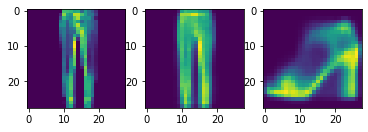

In [216]:
fig, axs = plt.subplots(1,3)
num = random.randint(0,100)
t = next(iter(test_loader))[0][num].float().view(1,1,28,28).to(device)

out, mu, logdir = M(t)
out = out.data

z = torch.randn(1, 2).to(device)
reconstructed_img = decodeur(z)
alea = reconstructed_img.view(28, 28).data

axs[0].imshow(t.view(28,28).cpu()) #Affiche le chiffre num de test_loader
axs[1].imshow(out.view(28,28).cpu()) #Reconstruction du chiffre par l'auto-encodeur
axs[2].imshow(alea.view(28,28).cpu().detach().numpy())# Reconstruction de bruit par l'auto-encodeur

In [248]:
data = [[] for _ in range(10)]
for i in range(10):
    data[i] = mnist_train.data[mnist_train.__dict__['targets'] == i]

enc =[[] for _ in range(10)]

for i in range(10):
    enc[i] = encodeur(data[i].float().to(device))
    
rep1 =[[[],[]] for _ in range(10)]
for i in range(10):
    for j in range(6000):
        """
        noise = torch.randn_like(enc[i][1][j]).to(device)
        x = np.array((enc[i][0][j] + torch.exp(0.5*enc[i][1][j])*noise).data.cpu())
        rep[i][0] += [x[0]]
        rep[i][1] += [x[1]]
        """
        rep1[i][0] += [float(enc[i][0][j][0].data.cpu())]
        rep1[i][1] += [float(enc[i][0][j][1].data.cpu())]
        
rep2 =[[[],[]] for _ in range(10)]
for i in range(10):
    for j in range(6000):
        """
        noise = torch.randn_like(enc[i][1][j]).to(device)
        x = np.array((enc[i][0][j] + torch.exp(0.5*enc[i][1][j])*noise).data.cpu())
        rep[i][0] += [x[0]]
        rep[i][1] += [x[1]]
        """
        rep2[i][0] += [float(enc[i][1][j][0].data.cpu())]
        rep2[i][1] += [float(enc[i][1][j][1].data.cpu())]

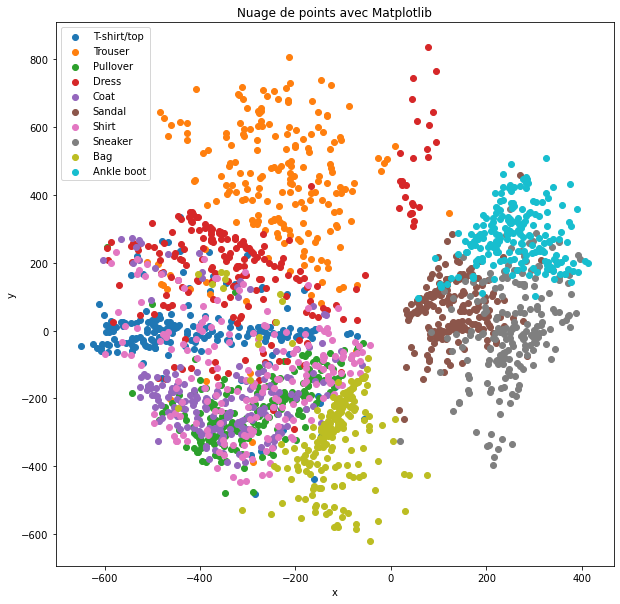

In [277]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(10,10))

colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for i in range(10):
    ax.scatter(rep1[i][0][200:400], rep1[i][1][200:400], c =colors[i], label = mnist_train.classes[i])

plt.title('Nuage de points avec Matplotlib')
plt.xlabel('x')
plt.ylabel('y')

ax.legend()
plt.savefig('ScatterPlot_03.png')
plt.show()

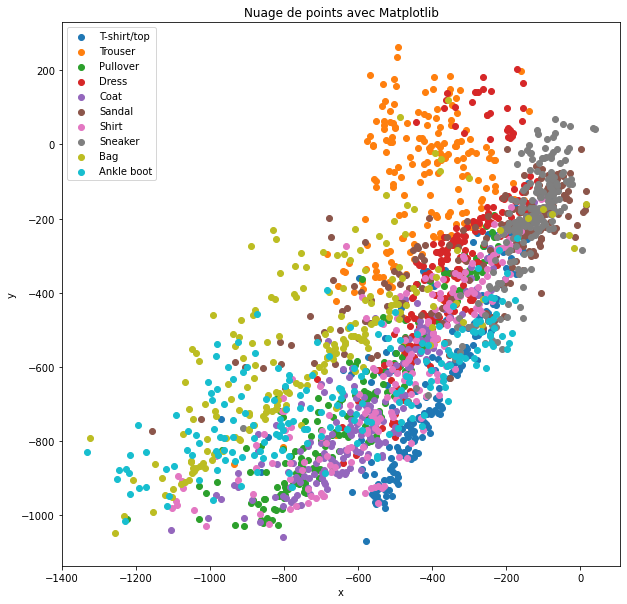

In [278]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig, ax = plt.subplots(figsize=(10,10))

for i in range(10):
    ax.scatter(rep2[i][0][300:500], rep2[i][1][300:500], c =colors[i], label = mnist_train.classes[i])

plt.title('Nuage de points avec Matplotlib')
plt.xlabel('x')
plt.ylabel('y')

ax.legend()
plt.savefig('ScatterPlot_03.png')
plt.show()

In [7]:
class Voiture:
    def __init__(self):
        self.x = 5
    
    def __len__(self):
        sl
        return 3
    
    def roue():
        print("ok", self.x)
        
    def s(self):
        print("pofjqsd")

In [ ]:
class lanbogr(Voiture):
    def __init__(self):
        super(MyModel, self).__init__()
        
    def roue():
        print("ok", self.x)

In [12]:
c = Voiture()
c.s()
Voiture.s()

pofjqsd


TypeError: s() missing 1 required positional argument: 'self'

In [6]:
len([1,2,3])

3